In [24]:
using Fretem, Potential, Alphabeta, PyPlot, Printf

### Part 1: Get collocation points and integration kernel for whole domain

In [25]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration

# Define Physical Domain
xratio = 20 # unit: angstrom
xavg = 50   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V_{eq}(x)$ and $p_{eq}(x)$ and $D$

In [26]:
k_eq = 0.5 # unit: kcal/mol/angstrom^2
V_eq = harmonic_well_k_mean(xref, k_eq, xavg)
rho_eq = get_rhoeq(V_eq, w0)
peq = rho_eq .* rho_eq
D = 4.845e9; # Diffusion coefficient, unit: angstrom^2 s-1

### Part 3: Set $C_{eq} = \frac{1}{\int \exp{(-V_{eq} (x))} dx}$

In [27]:
C_eq = 1 / sum(w0 .* exp.(-V_eq))
sigma_by_Ceq  = 1 / (C_eq  * sqrt(2 * pi)) 

1.0000000000000002

$\sigma = (\frac{1}{2k})^{1/2}$

In [28]:
sigma_by_keq = 1 / sqrt(2 * k_eq)

1.0

### Part 4: Set Gaussian $p(x) = \frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$

In [29]:
factor1 = -1 / 2
factor2  = 1 / ( sigma_by_keq * sqrt(2 * pi))
peq_gaussian = factor2 .* exp.(factor1 .* ((xref .- xavg) ./ sigma_by_keq).^2)
peq_gaussian = max.(peq_gaussian, 1e-10);

### Part 5-1: Plot $V_{eq}(x)$ vs $x$ and $p_{eq}(x)$ vs $x$

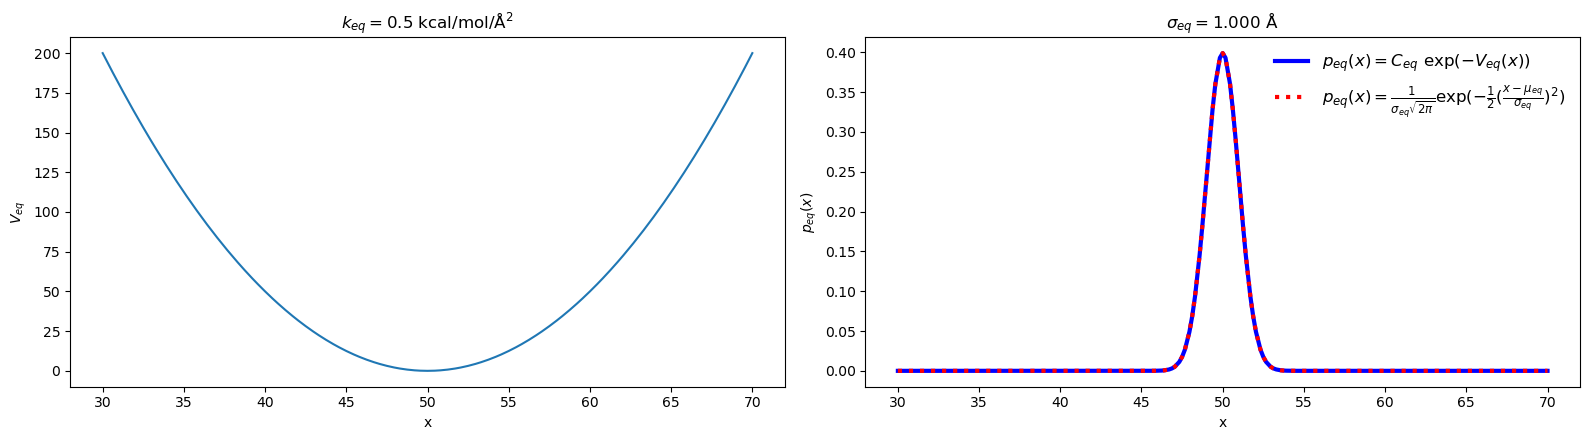

In [30]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,4.5))

ax = axes[1]
ax.plot(xref, V_eq)
ax.set_xlabel("x")
ax.set_ylabel("\$ V_{eq}}(x) \$")
title = @sprintf "\$ k_{eq} = %3.1f \$ kcal/mol/Å\$^2\$" k_eq
ax.set_title(title)

ax = axes[2]
label1 = "\$ p_{eq}(x) = C_{eq}~\\exp(-V_{eq}(x))\$"
label2 = "\$ p_{eq}(x) = \\frac{1}{\\sigma_{eq} \\sqrt{2\\pi}}\\exp{(-\\frac{1}{2}(\\frac{x-\\mu_{eq}}{\\sigma_{eq}})^2)} \$"
ax.plot(xref, peq, label=label1, linestyle="-", linewidth=3, color="blue")
ax.plot(xref, peq_gaussian, label=label2, linestyle=":", linewidth=3, color="red")

ax.set_xlabel("x")
ax.set_ylabel("\$ p_{eq}(x)\$")
title = @sprintf "\$ \\sigma_{eq} = %3.3f\$ Å" sigma_by_keq
ax.set_title(title)
ax.legend(frameon=false, fontsize=12)
plt.tight_layout()
#plt.savefig("k0.5.png", dpi=100)
plt.show()

### Part 5-2: Plot $V_0(x)$ vs $x$ and $p_0(x)$ vs $x$

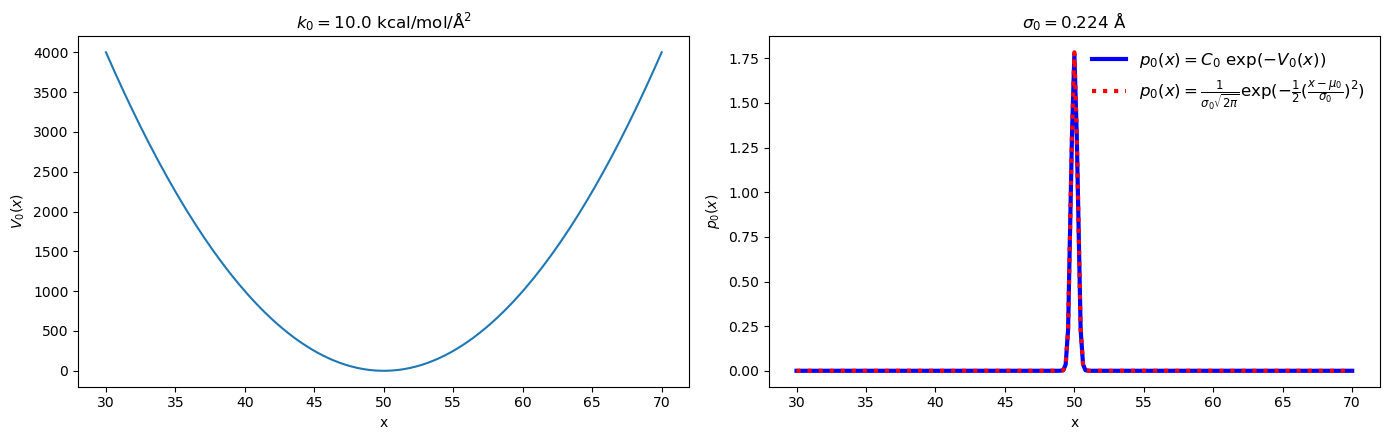

In [23]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14,4.5))

ax = axes[1]
ax.plot(xref, V_eq)
ax.set_xlabel("x")
ax.set_ylabel("\$ V_0(x) \$")
title = @sprintf "\$ k_0 = %3.1f \$ kcal/mol/Å\$^2\$" k_eq
ax.set_title(title)

ax = axes[2]
label1 = "\$ p_0(x) = C_0~\\exp(-V_0(x))\$"
label2 = "\$ p_0(x) = \\frac{1}{\\sigma_0 \\sqrt{2\\pi}}\\exp{(-\\frac{1}{2}(\\frac{x-\\mu_0}{\\sigma_0})^2)} \$"
ax.plot(xref, peq, label=label1, linestyle="-", linewidth=3, color="blue")
ax.plot(xref, peq_gaussian, label=label2, linestyle=":", linewidth=3, color="red")

ax.set_xlabel("x")
ax.set_ylabel("\$ p_0(x)\$")
title = @sprintf "\$ \\sigma_0 = %3.3f\$ Å" sigma_by_keq
ax.set_title(title)
ax.legend(frameon=false, fontsize=12)
plt.tight_layout()
#plt.savefig("k10.png", dpi=100)
plt.show()

### Part 6: Set $k_0$ and $p(x,0)$ and $C_0$

In [116]:
k0 = 1.1 # unit: kcal/mol/angstrom^2
sigma0 = 1 / sqrt(2 * k0)
mu_0 = 50
V0 = harmonic_well_k_mean(xref, k0, mu_0)
p0, C0 = get_peq_c(V0, w0);

### Part 7: Plot $\rho(x,0)$

In [117]:
rho0_by_rhoeq = p0 ./ rho_eq;

In [118]:
first = pi^(-1/4) * sqrt(k0 / sqrt(k_eq))
second = (k_eq / 2) - k0
exp_term = exp.(second .* (xref .- mu_0).^2)
rho0_by_k = first .* exp_term
rho0_by_k = max.(rho0_by_k, 1e-10);

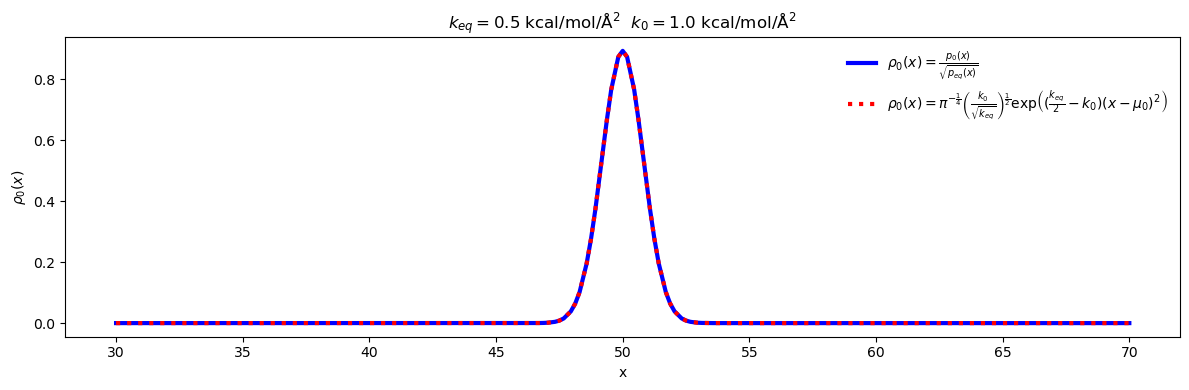

In [35]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 4))

label1 = "\$ \\rho_0(x) = \\frac{p_0(x)}{\\sqrt{p_{eq}(x)}} \$"
temp1 = "\$ \\rho_0(x) =  \\pi^{-\\frac{1}{4}} \\left(\\frac{k_0}{\\sqrt{k_{eq}}}\\right)^{\\frac{1}{2}}"
temp2 = "\\exp{\\left( (\\frac{k_{eq}}{2}- k_0 ) (x - \\mu_0 )^2 \\right)} \$"
label2 = @sprintf "%s %s" temp1 temp2
ax.plot(xref, rho0_by_rhoeq, label=label1, linestyle="-", linewidth=3, color="blue")
ax.plot(xref, rho0_by_k, label=label2, linestyle=":", linewidth=3, color="red")
ax.set_xlabel("x")
ax.set_ylabel("\$ \\rho_0(x) \$")
ax.legend(frameon=false)
title = @sprintf "\$ k_{eq} = %3.1f \$ kcal/mol/Å\$^2\$  \$ k_{0} = %3.1f \$ kcal/mol/Å\$^2\$" k_eq k0
ax.set_title(title)
plt.tight_layout()
#plt.savefig("rho0_analytical.png", dpi=100)
plt.show()

### Part 8: Get eigenvalues and eigenvectors

In [62]:
Nv = 72 # Number of eigenvectors
Lambdas, Qx, rho = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, peq, D, Nv);

### Part 9: Get $a_i = \left<\alpha_{t0} | \psi_i \right>$, where $i=1,\cdots,N_v$ and get $p_{appr}$

In [ ]:
a_array = Fretem.get_coefficients_by_proj(w0, rho0_by_k, Qx, Nv);
#p0_appr = Fretem.rebuild_p0_by_Qx_carray(Nv, c_array, Qx, rho_eq)

### Part 10: $\rho_{appr}(x) = a_1 \psi_1(x)+ a_2 \psi_2(x)+\cdots+ a_n \psi_n(x) $

In [120]:
Nv_sele = 36
N = size(Qx)[1]
rho0_appr = zeros(N)
for idx_eigv in 1:Nv_sele
    rho0_appr = rho0_appr .+ (a_array[idx_eigv] .* Qx[:, idx_eigv])
end

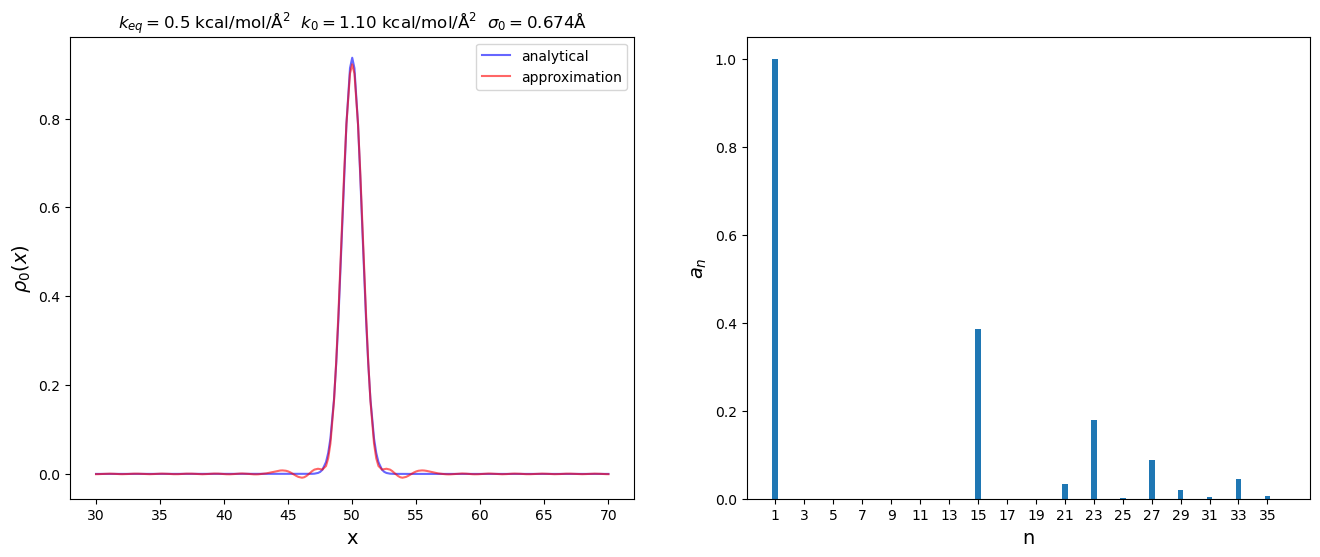

In [121]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,6))

ax = axes[1]
ax.plot(xref, rho0_by_k, color="blue", alpha=0.6, label="analytical")
ax.plot(xref, rho0_appr, color="red", alpha=0.6, label="approximation")
ax.legend()
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("\$ \\rho_0(x) \$", fontsize=14)
title = @sprintf "\$ k_{eq} = %3.1f \$ kcal/mol/Å\$^2\$  \$ k_{0} = %1.2f \$ kcal/mol/Å\$^2\$  \$\\sigma_0=%1.3f\$Å" k_eq k0 sigma0
ax.set_title(title)

w = 0.4
xlist = 1:36
xticks = 1:2:35
ax = axes[2]
ax.bar(xlist, abs.(a_array), w)
ax.set_xticks(xticks)
ax.set_ylabel("\$ a_n \$", fontsize=14)
ax.set_xlabel("n", fontsize=14)

figname = @sprintf "appr_k0_%.2f.png" k0
plt.savefig(figname, dpi=100)

plt.show()

### Part 10-1: Multiple Plots

In [65]:
function twoplots(ax1, ax2, k0, k_eq, mu, Qx, Nv, w0)
    a_array, rho0_analytical, rho0_appr = get_coeffi_rho0_analy_appr(k0, k_eq, mu, Qx, Nv, w0)
    rho_plot(ax1, rho0_analytical, rho0_appr, k0)
    bar_plot(ax2, Nv, a_array)
end

function twoplots_mu(ax1, ax2, k0, k_eq, mu, Qx, Nv, w0)
    a_array, rho0_analytical, rho0_appr = get_coeffi_rho0_analy_appr(k0, k_eq, mu, Qx, Nv, w0)
    rho_plot_withmu(ax1, rho0_analytical, rho0_appr, k0, mu)
    bar_plot(ax2, Nv, a_array)
end

function rho_plot(ax, rho0_analytical, rho0_appr, k0)
    sigma0 = 1 / sqrt(2 * k0)
    ax.plot(xref, rho0_analytical, color="blue", alpha=0.6, label="analytical")
    ax.plot(xref, rho0_appr, color="red", alpha=0.6, label="approximation")
    ax.legend(frameon=false)
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("\$ \\rho_0(x) \$", fontsize=14)
    title = @sprintf "\$ k_{0} = %1.2f \$ kcal/mol/Å\$^2\$  \$\\sigma_0=%1.3f\$Å" k0 sigma0
    ax.set_title(title)
end

function rho_plot_withmu(ax, rho0_analytical, rho0_appr, k0, mu)
    sigma0 = 1 / sqrt(2 * k0)
    ax.plot(xref, rho0_analytical, color="blue", alpha=0.6, label="analytical")
    ax.plot(xref, rho0_appr, color="red", alpha=0.6, label="approximation")
    ax.axvline(mu, color="grey", alpha=0.3)
    ax.legend(frameon=false)
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("\$ \\rho_0(x) \$", fontsize=14)
    title = @sprintf "\$ k_{0} = %1.2f \$ kcal/mol/Å\$^2\$  \$\\sigma_0=%1.3f\$Å" k0 sigma0
    ax.set_title(title)
end


function bar_plot(ax, Nv, a_array)
    w = 0.4
    xlist = 1:Nv
    xticks = 1:4:Nv
    ax.bar(xlist, abs.(a_array), w)
    ax.set_xticks(xticks)
    ax.set_ylabel("\$ |a_n| \$", fontsize=14)
    ax.set_xlabel("n", fontsize=14)
end

function get_coeffi_rho0_analy_appr(k0, k_eq, mu, Qx, Nv, w0)
    rho0_analytical = get_rho0_analytical(k0, k_eq, mu)
    a_array = Fretem.get_coefficients_by_proj(w0, rho0_analytical, Qx, Nv)
    rho0_appr = get_rho0_appr(Qx, a_array, Nv)
    return a_array, rho0_analytical, rho0_appr
end

function get_rho0_analytical(k0, k_eq, mu)
    first = pi^(-1/4) * sqrt(k0 / sqrt(k_eq))
    second = (k_eq / 2) - k0
    exp_term = exp.(second .* (xref .- mu).^2)
    rho0_by_k = first .* exp_term
    rho0_by_k = max.(rho0_by_k, 1e-10);
    return rho0_by_k
end

function get_rho0_appr(Qx, a_array, Nv_sele)
    N = size(Qx)[1]
    rho0_appr = zeros(N)
    for idx_eigv in 1:Nv_sele
        rho0_appr = rho0_appr .+ (a_array[idx_eigv] .* Qx[:, idx_eigv])
    end
    return rho0_appr
end

get_rho0_appr (generic function with 1 method)

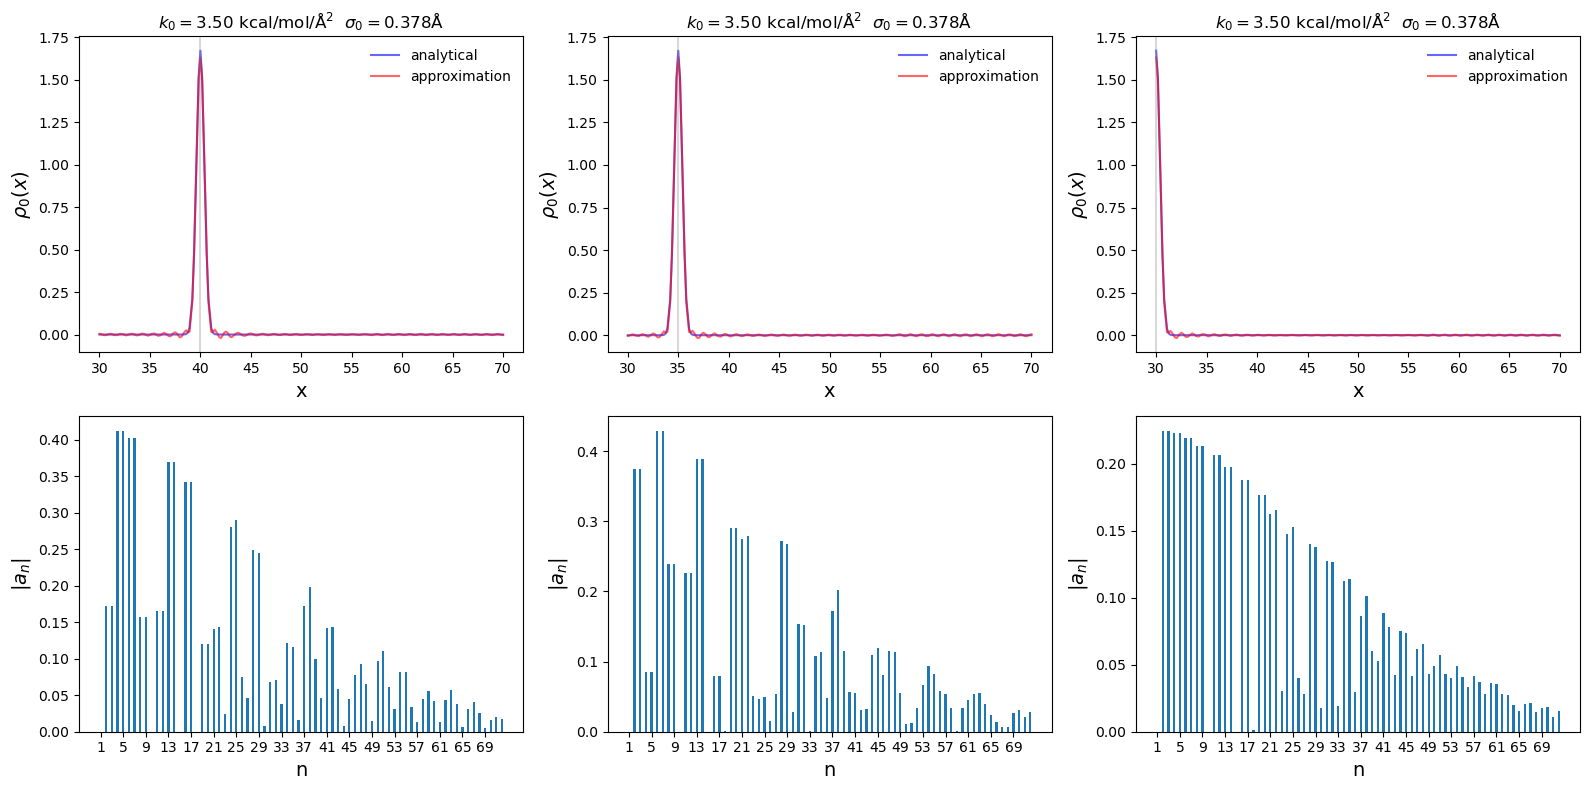

In [76]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16,8))


k0 = 3.5
mu0 = 40
twoplots_mu(axes[1,1], axes[2,1], k0, k_eq, mu0, Qx, Nv, w0)

k0 = 3.5
mu0 = 35
twoplots_mu(axes[1,2], axes[2,2], k0, k_eq, mu0, Qx, Nv, w0)

k0 = 3.5
mu0 = 30
twoplots_mu(axes[1,3], axes[2,3], k0, k_eq, mu0, Qx, Nv, w0)

plt.tight_layout()
#plt.savefig("various_mu_Nv72_3.png", dpi=100)
plt.show()

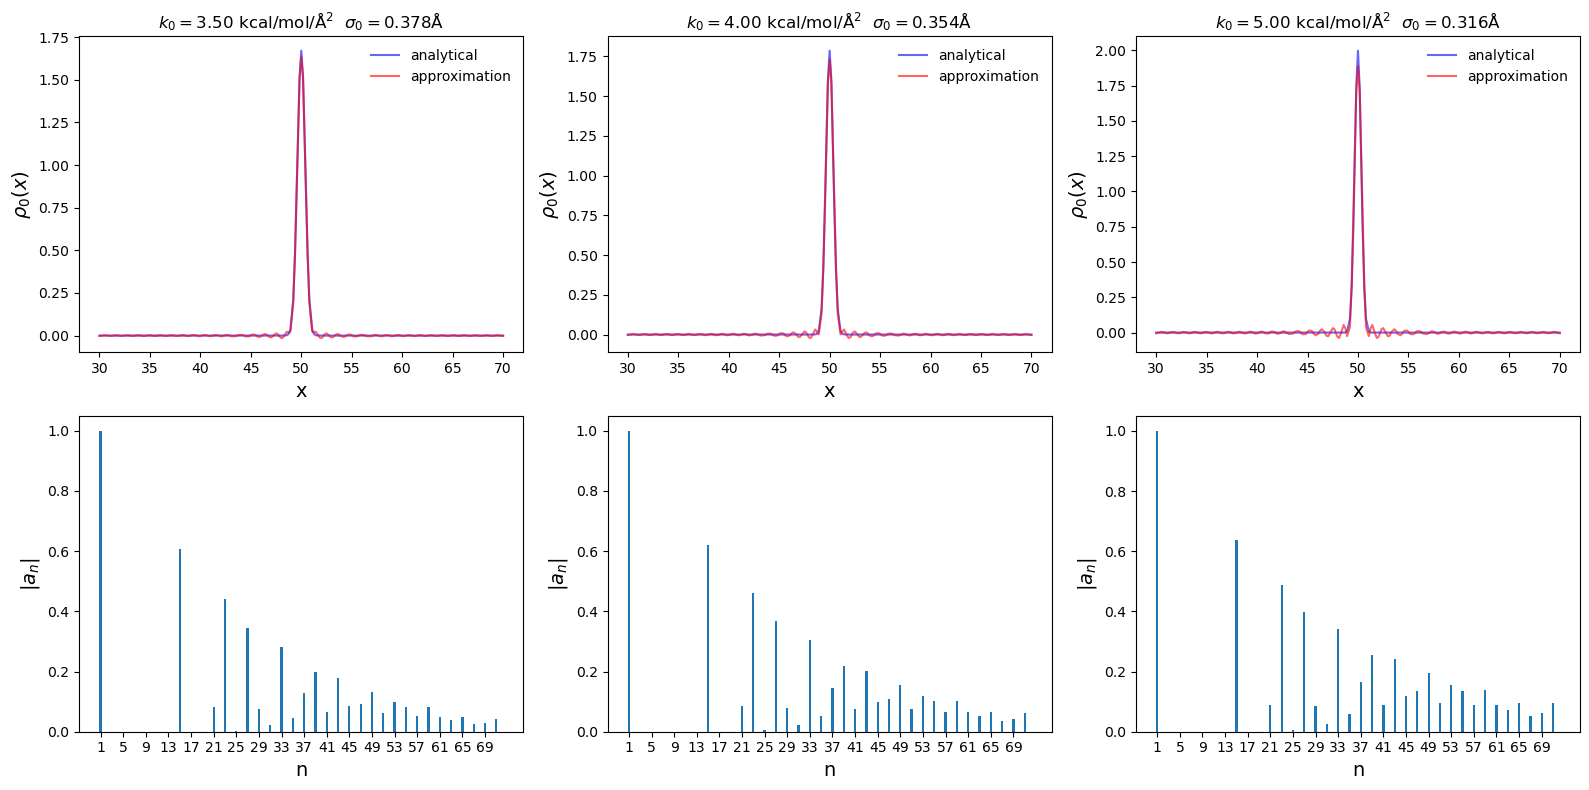

In [69]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16,8))

k0 = 3.5
mu0 = 50
twoplots(axes[1,1], axes[2,1], k0, k_eq, mu0, Qx, Nv, w0)

k0 = 4
mu0 = 50
twoplots(axes[1,2], axes[2,2], k0, k_eq, mu0, Qx, Nv, w0)

k0 = 5
mu0 = 50
twoplots(axes[1,3], axes[2,3], k0, k_eq, mu0, Qx, Nv, w0)

plt.tight_layout()
#plt.savefig("various_k_Nv72.png", dpi=100)
plt.show()